In [14]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix,f1_score
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [15]:
scantronReading_38_df = pd.read_csv('../dataframes/scantronReading_38.csv')
scantronReading_38_df.head()

,studentId,level,dataSource,is_proficient,proficient_score,course_AIDELIB7-8NC,course_AIDSTU6-12NC,course_ARTHIS7-8,course_Advisory 5,course_Advisory 6,...,school_Elementary School F,school_Intermediate School E,school_Middle School A,school_Middle School C,school_Middle School D,school_Middle School F,iready_math,iready_reading,bbb_literacy,past_proficient_score
0,44777,7,value_scantronReading,False,0.993342,False,False,False,False,True,...,False,False,True,False,False,False,0,0,0,0.969279
1,44783,7,value_scantronReading,False,0.997179,False,False,False,False,True,...,False,False,True,False,False,False,0,0,0,1.009665
2,44784,6,value_scantronReading,False,0.947277,False,False,False,True,False,...,False,False,True,False,False,False,0,0,0,0.934354
3,44807,7,value_scantronReading,True,1.014669,False,False,False,False,True,...,False,False,True,False,False,False,0,0,0,1.028650
4,44809,7,value_scantronReading,False,0.934665,False,False,False,False,True,...,False,False,True,False,False,False,0,0,0,0.949085


PCA

In [16]:
print(scantronReading_38_df.isnull().sum())  

studentId                    0
level                        0
dataSource                   0
is_proficient                0
proficient_score             0
                          ... 
school_Middle School F       0
iready_math                  0
iready_reading               0
bbb_literacy                 0
past_proficient_score     5280
Length: 142, dtype: int64


In [17]:
scantronReading_38_df = scantronReading_38_df.dropna(subset=['past_proficient_score'])
print(scantronReading_38_df.isnull().sum())  

studentId                 0
level                     0
dataSource                0
is_proficient             0
proficient_score          0
                         ..
school_Middle School F    0
iready_math               0
iready_reading            0
bbb_literacy              0
past_proficient_score     0
Length: 142, dtype: int64


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(scantronReading_38_df.drop(['proficient_score', 'studentId', 'level','dataSource','is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")

Number of components needed: 46
Cumulative explained variance: 0.8047655280046804


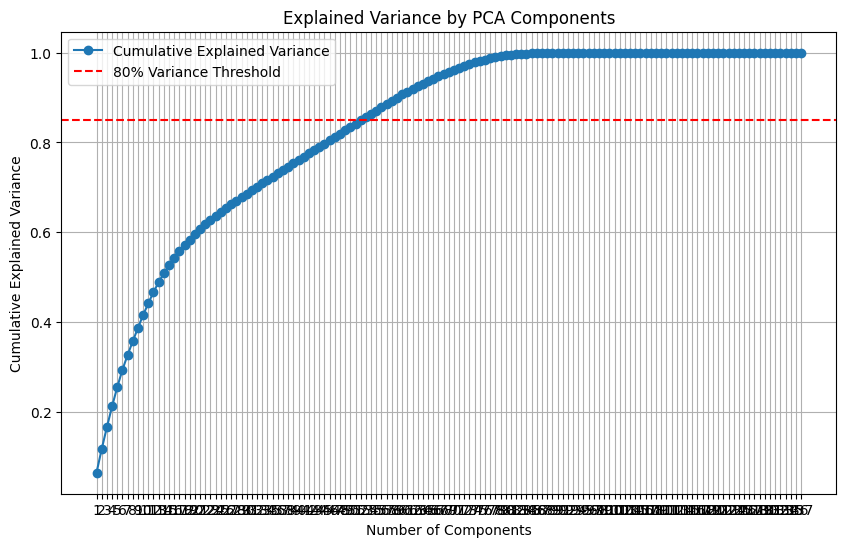

Number of components needed: 46


In [19]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [20]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_47_pcs_df = X_pca_df.iloc[:, :47].copy()

In [21]:
print(pca.components_.shape)
print(scantronReading_38_df.columns)

cols_drop = ['proficient_score', 'studentId', 'level','dataSource','is_proficient']
columns_to_drop = [col for col in cols_drop if col in scantronReading_38_df.columns]
feature_names = scantronReading_38_df.drop(columns=columns_to_drop).columns

(137, 137)
Index(['studentId', 'level', 'dataSource', 'is_proficient', 'proficient_score',
       'course_AIDELIB7-8NC', 'course_AIDSTU6-12NC', 'course_ARTHIS7-8',
       'course_Advisory 5', 'course_Advisory 6',
       ...
       'school_Elementary School F', 'school_Intermediate School E',
       'school_Middle School A', 'school_Middle School C',
       'school_Middle School D', 'school_Middle School F', 'iready_math',
       'iready_reading', 'bbb_literacy', 'past_proficient_score'],
      dtype='object', length=142)


In [22]:
components = pca.components_[:47]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component          Top Feature
0                   PC1      course_HOMEROOM
1                   PC1         course_HWK-4
2                   PC1        course_MATH 3
3                   PC1    course_LANGUAGE 3
4                   PC1     course_SCIENCE 3
..                  ...                  ...
230                PC47     course_Drama 7-8
231                PC47  course_CONTISSU 7-8
232                PC47   course_CREAWRT 7-8
233                PC47  course_BAND 7 Brass
234                PC47     course_ARTHIS7-8

[235 rows x 2 columns]


In [23]:
top_features_df.head(15)

,Principal Component,Top Feature
0,PC1,course_HOMEROOM
1,PC1,course_HWK-4
2,PC1,course_MATH 3
3,PC1,course_LANGUAGE 3
4,PC1,course_SCIENCE 3
5,PC2,course_CivicsGr 7
6,PC2,course_Geog Gr7
7,PC2,course_English Gr 7
8,PC2,course_Math 7
9,PC2,course_LifeSci Gr7


In [24]:
positive_correlations = {}
negative_correlations = {}

# Iterate through the loadings for each component
for pc in feature_loadings_df.columns:
    # Get the features with positive correlations (largest positive values)
    positive_features = feature_loadings_df[pc][feature_loadings_df[pc] > 0].sort_values(ascending=False)
    negative_features = feature_loadings_df[pc][feature_loadings_df[pc] < 0].sort_values(ascending=True)
    
    # Store the positive and negative correlations
    positive_correlations[pc] = positive_features
    negative_correlations[pc] = negative_features

# Print the results
print("Positive Correlations:")
for pc, features in positive_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 positively correlated features

print("\nNegative Correlations:")
for pc, features in negative_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 negatively correlated features

Positive Correlations:
PC1: course_HOMEROOM      0.227837
course_HWK-4         0.211805
course_MATH 3        0.207753
course_LANGUAGE 3    0.207753
course_PE 3          0.207753
Name: PC1, dtype: float64
PC2: course_CivicsGr 7      0.270038
course_Geog Gr7        0.269937
course_English Gr 7    0.267989
course_Math 7          0.225944
course_LifeSci Gr7     0.213316
Name: PC2, dtype: float64
PC3: course_English Gr 8    0.382861
course_WLDHIS 1500     0.382861
course_PhySci Gr 8     0.382861
course_Advisory 8      0.313226
course_CareerPrepA5    0.313226
Name: PC3, dtype: float64
PC4: course_MATH 4        0.292314
course_SCIENCE 4     0.292314
course_LANGUAGE 4    0.292314
course_READING 4     0.292314
course_SOC ST 4      0.292314
Name: PC4, dtype: float64
PC5: course_EnrichmtP6         0.300754
school_Middle School A    0.265680
course_English LA 5       0.264281
course_Science Gr 5       0.261940
course_SocialStuGr5       0.256784
Name: PC5, dtype: float64
PC6: course_MATH 6         

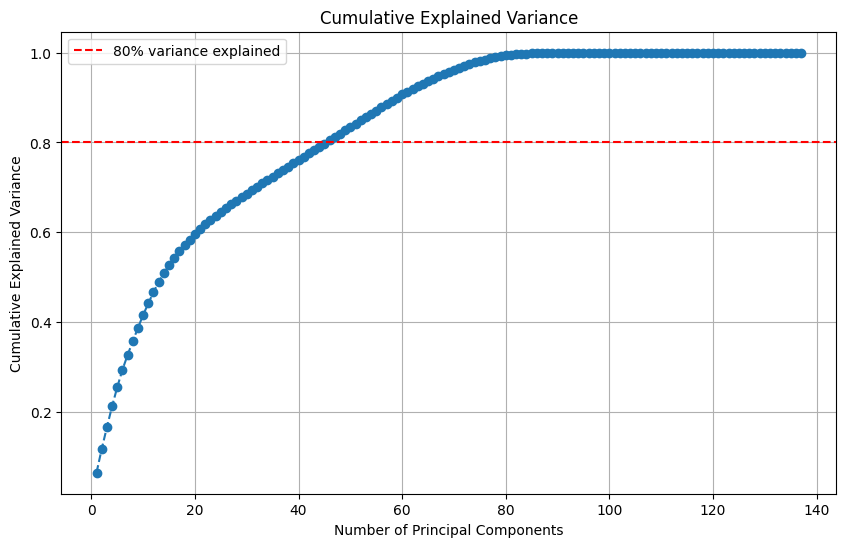

In [25]:
# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

training on PCA

In [26]:
X_PCA = first_47_pcs_df  # PCA-transformed features
y_PCA = scantronReading_38_df['proficient_score']
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.20, random_state=123)
print(X_train_PCA.shape)

(12144, 47)


In [27]:

'''
max_depth_values = [18,23,32]
n_estimators_value = [100,250,300,350]
param_grid = {'max_depth' : list(max_depth_values), 'n_estimators' : list(n_estimators_value)}

#Grid Search to find the best hyperparameters 
print("Running Grid Search")
rf_regressor_PCA = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid_PCA = GridSearchCV(rf_regressor_PCA, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search_PCA = rf_grid_PCA.fit(X_train_PCA, y_train_PCA)

print("Done")
rf_best_params_PCA = rf_grid_search_PCA.best_params_

rf_best_params_PCA
'''
#{'max_depth': 18, 'n_estimators': 300}


'\nmax_depth_values = [18,23,32]\nn_estimators_value = [100,250,300,350]\nparam_grid = {\'max_depth\' : list(max_depth_values), \'n_estimators\' : list(n_estimators_value)}\n\n#Grid Search to find the best hyperparameters \nprint("Running Grid Search")\nrf_regressor_PCA = RandomForestRegressor()\n\n# will have a 3-fold cross validation \nrf_grid_PCA = GridSearchCV(rf_regressor_PCA, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\nrf_grid_search_PCA = rf_grid_PCA.fit(X_train_PCA, y_train_PCA)\n\nprint("Done")\nrf_best_params_PCA = rf_grid_search_PCA.best_params_\n\nrf_best_params_PCA\n'

In [28]:
rf_model_PCA = RandomForestRegressor(max_depth=18, n_estimators=300)
rf_model_PCA.fit(X_train_PCA,y_train_PCA)

RandomForestRegressor(max_depth=18, n_estimators=300)

Metrics

In [29]:
y_rf_pred= rf_model_PCA.predict(X_test_PCA)
rf_rmse = mean_squared_error(y_test_PCA, y_rf_pred, squared=False)
rf_r2 = r2_score(y_test_PCA, y_rf_pred)

threshold = 1
y_rf_pred_bool = y_rf_pred >= threshold
y_test_bool = y_test_PCA >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_rf_pred_bool, y_test_bool))

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))        

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.87      0.89      1949
        True       0.78      0.85      0.81      1087

    accuracy                           0.86      3036
   macro avg       0.85      0.86      0.85      3036
weighted avg       0.87      0.86      0.86      3036

[RF] Root Mean Squared Error: 0.07165013875297396
[RF] R2: 0.5811397012127342


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
micro_f1 = f1_score(y_test_bool, y_rf_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.8616600790513834
